## Identify peaks per cluster

In [357]:
import numpy as np
import os
import sys
import logging
import collections
import matplotlib.pyplot as plt
import gzip
import glob
import loompy
import pybedtools
from pybedtools import BedTool
import MACS2
import multiprocessing as mp
from typing import *

sys.path.append('/home/camiel/chromograph/')
from chromograph.peak_calling.utils import *            
from chromograph.pipeline import config
from  chromograph.peak_calling import call_MACS
import shutil

logger = logging.getLogger()
logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%H:%M:%S')

from chromograph.pipeline import config
config = config.load_config()

# Parameters
ds = loompy.connect('/data/proj/scATAC/chromograph/build_20191206/Cerebellum.loom')
logging.info(f'ds connection: {ds.shape}')

17:38:22 INFO     ds connection: (617643, 17811)


In [431]:
ds.attrs.keys()

['CreationDate',
 'LOOM_SPEC_VERSION',
 'bin_max_cutoff',
 'bin_min_cutoff',
 'bin_size',
 'cellranger-atac_version',
 'level',
 'radius',
 'reference_assembly',
 'reference_assembly_accession',
 'reference_assembly_fasta_url',
 'reference_organism',
 'reference_version',
 'tissue']

In [3]:
class Peak_caller:
    def __init__(self) -> None:
        """
        Generate fragments piles based on cluster identities and use MACS to call peaks
        
        Args:
            ds                    Loom connection

        Remarks:
        
        """
        self.config = config.load_config()
        self.peakdir = os.path.join(self.config.paths.build, 'peaks')
        logging.info("Peak Caller initialised")
    
    def fit(self, ds: loompy.LoomConnection) -> None:
        """
        Generate fragments piles based on cluster identities and use MACS to call peaks
        
        Args:

        Returns:
        
        Remarks:
        
        """
        
        ## Check if location for peaks and compounded fragments exists
        if not os.path.isdir(self.peakdir):
            os.mkdir(self.peakdir)

        config = config.load_config()
        pf = os.path.join(config.paths.build, 'peaks')

        if not os.path.isdir(self.peakdir):
            os.mkdir(self.peakdir)   

        chunks = []
        for i in np.unique(ds.ca['Clusters']):
            cells = ds.ca["sample", "barcode"][ds.ca['Clusters'] == i]
            files = [os.path.join(config.paths.samples, x[0], 'fragments', f'{x[1]}.tsv.gz') for x in cells]
            chunks.append([i,files])

        logging.info('Start merging fragments by cluster')
        piles = []
        for ck in chunks:
            files = np.array(ck[1])
            ex = np.array([os.path.exists(x) for x in files])
            files = files[ex]

            fmerge = os.path.join(pf, f'fragments_{ck[0]}.tsv.gz')
            with open(fmerge, 'wb') as out:
                for f in files:
                    with open(f, 'rb') as file:
                        shutil.copyfileobj(file, out)
            piles.append([ck[0], fmerge])
            logging.info(f'Finished with cluster {ck[0]}')
            
        if __name__ == '__main__':
            jobs = []
            for pile in piles:
                p = mp.Process(target=call_MACS, args=(pile, self.peakdir, self.config.paths.MACS,))
                jobs.append(p)
                p.start()
                
        ## Compound the peak lists
        peaks = [BedTool(x) for x in glob.glob(os.path.join(self.peakdir, '*.narrowPeak'))]
        logging.info('Identified on average {} peaks per cluster'.format(np.int(np.mean([len(x) for x in peaks]))))
        peaks_all = peaks[0].cat(*peaks[1:])
        logging.info('Identified {} peaks after compounding list'.format(len(peaks_all)))
        
        return peaks_all
            
peak_caller = Peak_caller()


19:02:11 INFO     Peak Caller initialised


In [428]:
with loompy.connect('/data/proj/scATAC/samples/10X232_1/10X232_1_GA.loom') as dsi:
    print(dsi.ra.keys())

['Accession', 'Gene', 'loc']


In [429]:
?loompy.combine

Signature:
loompy.combine(
    files: List[str],
    output_file: str,
    key: str = None,
    file_attrs: Dict[str, str] = None,
    batch_size: int = 1000,
    convert_attrs: bool = False,
) -> None
Docstring:
Combine two or more loom files and save as a new loom file

Args:
        files (list of str):    the list of input files (full paths)
        output_file (str):      full path of the output loom file
        key (string):           Row attribute to use to verify row ordering
        file_attrs (dict):      file attributes (title, description, url, etc.)
        batch_size (int):       limits the batch or cols/rows read in memory (default: 1000)
        convert_attrs (bool):   convert file attributes that differ between files into column attributes

Returns:
        Nothing, but creates a new loom file combining the input files.
        Note that the loom files must have exactly the same
        number of rows, and must have exactly the same column attributes.
        Named la

In [359]:
# IDs = [f'{x[0]}:{x[1]}' for x in ds.ca["sample", "barcode"]]
# ds.ca['CellID'] = IDs

7 7


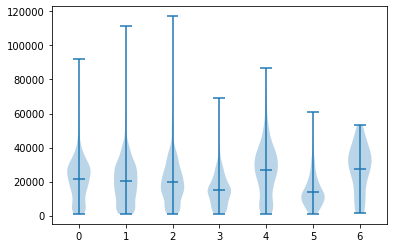

In [5]:
data = [ds.ca['passed_filters'][ds.ca['Clusters'] == x] for x in np.unique(ds.ca['Clusters'])]
# data = [np.log10(ds.ca['passed_filters'][ds.ca['Clusters'] == x]) for x in np.unique(ds.ca['Clusters'])]
print(len(data), len(np.unique(ds.ca['Clusters'])))
plt.violinplot(data, positions=np.unique(ds.ca['Clusters']), showmeans=True);

In [6]:
# for clus in np.unique(ds.ca['Clusters']):
#     cas = ds.ca['fragments'][ds.ca['Clusters'] == clus]
#     frags = [strFrags_to_list(x) for x in cas]
#     frags = [x for l in frags for x in l]
#     logging.info("Total fragments in cluster {}:  {}".format(clus, len(frags)))

#     fbed = os.path.join(pf, "fragments_cluster_{}.bed.gz".format(clus))
#     fpeaks = os.path.join(pf, "cluster_{}".format(clus))

#     print(g, fpeaks)
#     bed = BedTool(frags)
#     bed.saveas(fbed)

#     ## Call Peaks
#     cmd = "{} callpeak -t {} -f BEDPE -g {} --nomodel --shift 100 --ext 200 --qval 5e-2 -B --SPMR -n {}".format(macs_path, fbed, g, fpeaks)
#     os.system(cmd)

#     logging.info('Called peaks for cluster {} out of {}'.format(clus, np.unique(ds.ca['Clusters'])))
    
#     ## We only need the narrowPeak file, so clean up the rest
#     os.system("rm {}".format(os.path.join(pf, 'cluster_' + str(clus) + '_peaks.xls'))
#     os.system("rm {}".format(os.path.join(pf, 'cluster_' + str(clus) + '_control_lambda.bdg'))
#     os.system("rm {}".format(os.path.join(pf, 'cluster_' + str(clus) + '_summits.bed'))

13374967


## Generate compound peak list and count peaks

In [10]:
## Get all the narrowPeak files

pf = '/data/proj/scATAC/chromograph/build_20191206/peaks/'

peaks = [BedTool(x) for x in glob.glob(os.path.join(pf, '*.narrowPeak'))]
logging.info('Identified on average {} peaks per cluster'.format(np.int(np.mean([len(x) for x in peaks]))))

peaks_all = peaks[0].cat(*peaks[1:]).saveas(os.path.join(pf, 'Compound_peaklist.narrowPeak'))
logging.info('Identified {} peaks after compounding list'.format(len(peaks_all)))

10:23:22 INFO     Identified on average 76138 peaks per cluster
10:23:43 INFO     Identified 229634 peaks after compounding list


In [2]:
## Merge Peak lists
pwdl = ['/data/proj/scATAC/chromograph/build_20191206/peaks/', '/data/proj/scATAC/chromograph/build_20191205/peaks/']

peaks = [BedTool(os.path.join(p, 'Compound_peaklist.narrowPeak')) for p in pwdl]
l = [len(x) for x in peaks]

logging.info(f'Length of the BedTools: {l}')

13:30:26 INFO     Length of the BedTools: [229634, 269373]


In [255]:
from chromograph.peak_calling.utils import *
# def extend_fields(feature, n):
#     fields = feature.fields[:]
#     while len(fields) < n:
#         fields.append('.')
#     return pybedtools.create_interval_from_list(fields)

# def add_ID(feature):
#     feature[3] = f'{feature[0]}:{feature[1]}-{feature[2]}'
#     return feature

# def add_strand(feature, strand):
#     feature[5] = strand
#     return feature

tmp = peaks[0].cat(peaks[1])
tmp = tmp.each(extend_fields, 6).each(add_ID).each(add_strand, '+').saveas('/data/proj/scATAC/chromograph/tmp/compound_peaks.bed')

logging.info(f'Length after merging {tmp.count()}')
tmp.head()

13:59:18 INFO     Length after merging 325484


chr1	180892	181154	chr1:180892-181154	.	+
 chr1	181357	181841	chr1:181357-181841	.	+
 chr1	190796	191880	chr1:190796-191880	.	+
 chr1	778221	779507	chr1:778221-779507	.	+
 chr1	788815	789212	chr1:788815-789212	.	+
 chr1	794857	795186	chr1:794857-795186	.	+
 chr1	817182	817417	chr1:817182-817417	.	+
 chr1	817850	818358	chr1:817850-818358	.	+
 chr1	818744	819631	chr1:818744-819631	.	+
 chr1	820146	820322	chr1:820146-820322	.	+
 

In [395]:
fpeaks = os.path.join(pwdl[0], 'Compounded_peaks.bed')
peaks_all = BedTool('/data/proj/scATAC/chromograph/build_20191206/peaks/Compound_peaklist.narrowPeak')
peaks_all = peaks_all.each(extend_fields, 6).each(add_ID).each(add_strand, '+').saveas(fpeaks)   ## Pad out the BED-file and save

In [396]:
peaks_all.count()

229634

In [285]:
# ## Change to right configs
# peakdir = pwdl[0]

# homer = os.path.join(config.paths.HOMER, 'annotatePeaks.pl')
# genes = os.path.join(config.paths.ref, 'genes', 'genes.gtf')
# motifs = os.path.join(config.paths.ref, 'regions', 'motifs.pfm')
# f_annot = os.path.join(peakdir, 'annotated_peaks.txt')
# cmd = f'{homer} {fpeaks} hg38 -gtf {genes} -m {motifs} > {f_annot}'

# os.system(cmd)

0

In [288]:
def read_HOMER_annotation(file):
    '''
    Read the output of HOMER into a numpy array
    '''
    table = []
    with open(file) as f:
        i = 0
        for line in f:
            if i == 0:
                cols = ['ID'] + line.split('\t')[1:]
                cols = [x.rstrip() for x in cols]
            if i > 0 :
                table.append([x.rstrip() for x in line.split('\t')])
            i += 1

    table = np.array(table)
    return table

table = read_HOMER_annotation(f_annot)
table.shape

(229634, 21)

In [330]:
peak_IDs = np.array([x[3] for x in peaks_all])

def reorder_by_IDs(mat, IDs):
    '''
    '''
    ## Create index dict
    idx = {k:v for v,k in enumerate(IDs)}
    
    ## Initiate empty matrix
    table = np.zeros(mat.shape, dtype=object)

    ## Populate matrix
    i = 0
    for x in range(table.shape[0]):
        table[idx[mat[x,0]],:] = mat[x,:]

    return np.array(ntable)

table = reorder_by_IDs(table, peak_IDs)

In [418]:
## Save as dict    
annot = {cols[i]: table[:,i] for i in range(table.shape[1])}

In [400]:
def Count_peaks(cells, sample_dir, f_peaks):
    '''
    Count peaks
    '''
    Count_dict = {k: {} for k in cells}
    peaks = BedTool(f_peaks)
    i = 0
    for x in cells:
        try:
            s, c = x.split(':')
            f = os.path.join(sample_dir, s, 'fragments', f'{c}.tsv.gz')
            cBed = BedTool(f)
            pks = peaks.intersect(cBed, wa=True)

            cDict = {}
            for line in pks:
                cDict[line[3]] = 1

            Count_dict[x] = cDict
            i += 1
            if i%1000==0:
                logging.info(f'Finished counting {i} cells')
        except:
            Count_dict[x] = []
    logging.info('Finished job')
    return Count_dict

Count_dict1 = Count_peaks(ds.ca['CellID'][:10], config.paths.samples, fpeaks)
Count_dict2 = Count_peaks(ds.ca['CellID'][10:20], config.paths.samples, fpeaks)
Count_dict3 = Count_peaks(ds.ca['CellID'][20:30], config.paths.samples, fpeaks)
dicts = [Count_dict1, Count_dict2, Count_dict3]
Counts = {k: v for d in dicts for k, v in d.items()}

18:57:07 INFO     Finished job
18:57:19 INFO     Finished job
18:57:33 INFO     Finished job


In [409]:
r_dict = {k: v for v,k in enumerate(annot['ID'])}

In [110]:
simple_annotation = np.array([x.split(' ')[0] for x in annot['Annotation']])

counts = {}
for x in np.unique(simple_annotation):
    counts[x] = np.sum(simple_annotation == x)
    
print(counts)

{'Intergenic': 115048, 'TTS': 9270, 'exon': 14124, 'intron': 169168, 'promoter-TSS': 17874}


In [415]:
from scipy import sparse
logging.info("Generating Sparse matrix")
col = []
row = []
v = []

cix = 0
for cell in ds.ca['CellID'][:30]:

    for key in (Counts[cell]):
        col.append(cix)
        row.append(r_dict[key])
        v.append(Counts[cell][key])
    cix+=1
matrix = sparse.coo_matrix((v, (row,col)), shape=(len(r_dict.keys()), len(ds.ca['CellID'][:30])))


09:43:45 INFO     Generating Sparse matrix


<229634x30 sparse matrix of type '<class 'numpy.int64'>'
	with 305655 stored elements in COOrdinate format>

In [ ]:
## Create loomfile
logging.info("Constructing loomfile")
floom = f'{ds.filename.split(".")[0]}_peaks.loom'

loompy.create(filename=floom, 
              layers=matrix, 
              row_attrs=annot, 
              col_attrs=dict(ds.ca),
              file_attrs=dict(ds.attrs))
self.loom = floom
logging.info("Loom peaks file saved as {}".format(floom))

In [427]:
dict(ds.attrs)

{'CreationDate': '20191203T111617.063130Z',
 'LOOM_SPEC_VERSION': '3.0.0',
 'bin_max_cutoff': 6035.0,
 'bin_min_cutoff': 431.0,
 'bin_size': 5000,
 'cellranger-atac_version': '1.2.0',
 'level': 5000,
 'radius': 0.42703993320465095,
 'reference_assembly': 'GRCh38',
 'reference_assembly_accession': 'GCA_000001405.15',
 'reference_assembly_fasta_url': 'ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/000/001/405/GCA_000001405.15_GRCh38/seqs_for_alignment_pipelines.ucsc_ids/GCA_000001405.15_GRCh38_no_alt_analysis_set.fna.gz',
 'reference_organism': 'Homo_sapiens',
 'reference_version': '1.2',
 'tissue': 'Cerebellum'}

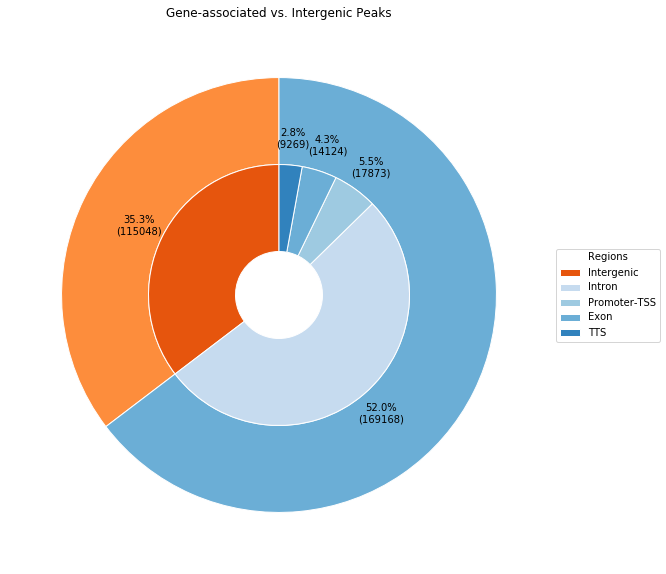

In [228]:
labels = 'Intergenic', 'Intron', 'Promoter-TSS', 'Exon', 'TTS'

fig, ax = plt.subplots(figsize = (12,10))

size = 0.4
vals = np.array([counts['Intergenic'], counts['intron'], counts['promoter-TSS'], counts['exon'], counts['TTS']])

cmap = plt.get_cmap("tab20c")
outer_colors = cmap(np.arange(2)*4 + 1)[[1,0],:]
inner_colors = cmap(np.array([0,1,2,3,4]))[::-1,:]

ax.pie([vals[0], sum(vals[1:])], radius=1, colors=outer_colors,
       wedgeprops=dict(width=size, edgecolor='w'), startangle=90)

def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d})".format(pct, absolute)

wedges, texts, autotexts = ax.pie(vals.flatten(), radius=1-size, colors=inner_colors, autopct=lambda pct: func(pct, vals), pctdistance=1.2, 
       wedgeprops=dict(width=size, edgecolor='w'), startangle=90)

ax.set(aspect="equal", title='Gene-associated vs. Intergenic Peaks')

ax.legend(wedges, labels,
          title="Regions",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.show()

In [195]:
enhancers = BedTool(os.path.join(config.paths.ref, 'regions', 'enhancer.bed'))
peak_list = BedTool([(annot['Chr'][x], str(annot['Start'][x]), str(annot['End'][x]), str(annot['ID'][x])) for x in range(len(annot['Chr']))]).saveas()
known_enhancers = peak_list.intersect(enhancers)
known_enhancers.head()

chr10	86837375	86837911	chr10:86837374-86837911
 chr2	424615	425353	chr2:424614-425353
 chr14	68722398	68722688	chr14:68722397-68722688
 chr4	39054312	39054814	chr4:39054311-39054814
 chr7	1429990	1430427	chr7:1429989-1430427
 chr1	99623401	99623806	chr1:99623349-99623806
 chr5	92561993	92562360	chr5:92561992-92562360
 chr3	11692204	11692418	chr3:11692203-11692418
 chr13	31750556	31751116	chr13:31750555-31751116
 chr2	219331481	219332131	chr2:219331480-219332903
 

In [200]:
enh_peaks = [x[3] for x in known_enhancers]

In [210]:
regs = []
nPeaks = len(annot['Annotation'])
for i in range(len(annot['Annotation'])):
    
    if annot['ID'][i] in enh_peaks:
        regs.append(annot['Annotation'][i])

    if i%10000 == 0:
        print(f'Finished {i} out of {nPeaks}')
enh_annotation = np.array([x.split(' ')[0] for x in regs])

Finished 0 out of 325484
Finished 10000 out of 325484
Finished 20000 out of 325484
Finished 30000 out of 325484
Finished 40000 out of 325484
Finished 50000 out of 325484
Finished 60000 out of 325484
Finished 70000 out of 325484
Finished 80000 out of 325484
Finished 90000 out of 325484
Finished 100000 out of 325484
Finished 110000 out of 325484
Finished 120000 out of 325484
Finished 130000 out of 325484
Finished 140000 out of 325484
Finished 150000 out of 325484
Finished 160000 out of 325484
Finished 170000 out of 325484
Finished 180000 out of 325484
Finished 190000 out of 325484
Finished 200000 out of 325484
Finished 210000 out of 325484
Finished 220000 out of 325484
Finished 230000 out of 325484
Finished 240000 out of 325484
Finished 250000 out of 325484
Finished 260000 out of 325484
Finished 270000 out of 325484
Finished 280000 out of 325484
Finished 290000 out of 325484
Finished 300000 out of 325484
Finished 310000 out of 325484
Finished 320000 out of 325484


In [213]:
regs = np.array([x.split(' ')[0] for x in regs])

enh_counts = {}
for x in np.unique(regs):
    enh_counts[x] = np.sum(enh_annotation == x)
    
print(enh_counts)

{'Intergenic': 52712, 'TTS': 3814, 'exon': 4691, 'intron': 77094, 'promoter-TSS': 2973}


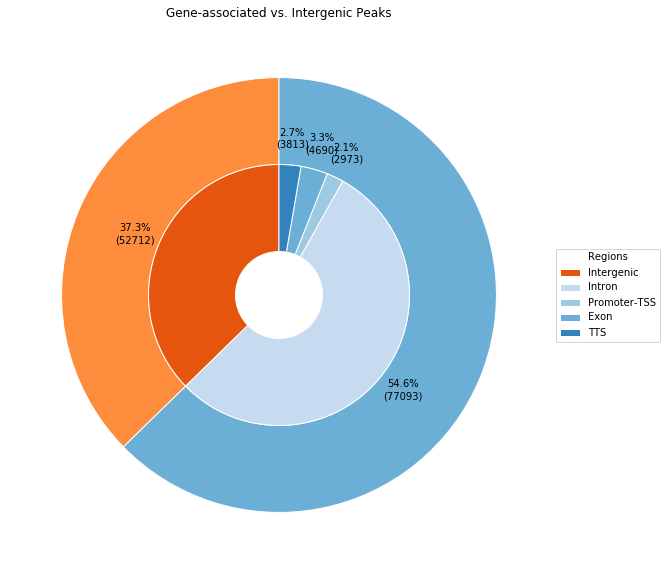

In [230]:
labels = 'Intergenic', 'Intron', 'Promoter-TSS', 'Exon', 'TTS'

fig, ax = plt.subplots(figsize = (12,10))

size = 0.4
vals = np.array([enh_counts['Intergenic'], enh_counts['intron'], enh_counts['promoter-TSS'], enh_counts['exon'], enh_counts['TTS']])

cmap = plt.get_cmap("tab20c")
outer_colors = cmap(np.arange(2)*4 + 1)[[1,0],:]
inner_colors = cmap(np.array([0,1,2,3,4]))[::-1,:]

ax.pie([vals[0], sum(vals[1:])], radius=1, colors=outer_colors,
       wedgeprops=dict(width=size, edgecolor='w'), startangle=90)

def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d})".format(pct, absolute)

wedges, texts, autotexts = ax.pie(vals.flatten(), radius=1-size, colors=inner_colors, autopct=lambda pct: func(pct, vals), pctdistance=1.2, 
       wedgeprops=dict(width=size, edgecolor='w'), startangle=90)

ax.set(aspect="equal", title='Gene-associated vs. Intergenic Peaks')

ax.legend(wedges, labels,
          title="Regions",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.show()

In [232]:
enh_counts['Intergenic'] / counts['Intergenic']

0.4581739795563591

In [250]:
peak_list = BedTool([(annot['Chr'][x], str(annot['Start'][x]), str(annot['End'][x]), str(annot['ID'][x])) for x in range(len(annot['Chr']))]).saveas()

for x in ['tss', 'transcripts', 'promoter', 'enhancer', 'dnase', 'ctcf', 'blacklist']:
    sub = BedTool(os.path.join(config.paths.ref, 'regions', f'{x}.bed'))
    peak_list = peak_list.subtract(sub, A=True)
    
for x in ['regulatory.gff', 'genes.gtf']:
    sub = BedTool(os.path.join(config.paths.ref, 'genes', x))
    peak_list = peak_list.subtract(sub, A=True)
    
peak_list.saveas()
print(peak_list.count())

29506


In [251]:
unknown_peaks = [x[3] for x in peak_list]

In [252]:
regs = []
nPeaks = len(annot['Annotation'])
for i in range(len(annot['Annotation'])):
    
    if annot['ID'][i] in unknown_peaks:
        regs.append(annot['Annotation'][i])

    if i%10000 == 0:
        logging.info(f'Finished {i} out of {nPeaks}')
unknown_annotation = np.array([x.split(' ')[0] for x in regs])

11:35:21 INFO     Finished 0 out of 325484
11:35:26 INFO     Finished 10000 out of 325484
11:35:30 INFO     Finished 20000 out of 325484
11:35:34 INFO     Finished 30000 out of 325484
11:35:39 INFO     Finished 40000 out of 325484
11:35:43 INFO     Finished 50000 out of 325484
11:35:48 INFO     Finished 60000 out of 325484
11:35:52 INFO     Finished 70000 out of 325484
11:35:56 INFO     Finished 80000 out of 325484
11:36:01 INFO     Finished 90000 out of 325484
11:36:05 INFO     Finished 100000 out of 325484
11:36:10 INFO     Finished 110000 out of 325484
11:36:14 INFO     Finished 120000 out of 325484
11:36:19 INFO     Finished 130000 out of 325484
11:36:23 INFO     Finished 140000 out of 325484
11:36:28 INFO     Finished 150000 out of 325484
11:36:32 INFO     Finished 160000 out of 325484
11:36:37 INFO     Finished 170000 out of 325484
11:36:42 INFO     Finished 180000 out of 325484
11:36:46 INFO     Finished 190000 out of 325484
11:36:51 INFO     Finished 200000 out of 325484
11:36:

In [253]:
unk_counts = {}
for x in np.unique(unknown_annotation):
    unk_counts[x] = np.sum(unknown_annotation == x)
    
print(unk_counts)

{'Intergenic': 28622, 'TTS': 580, 'promoter-TSS': 304}


In [254]:
unk_counts['Intergenic'] / counts['Intergenic']

0.24878311661219665

In [97]:
# for x in Gencode[0]:
#     print(x)
# for x in ensemble[0]:
#     print(x)
Gencode.head()

##gff-version 3
 #description: evidence-based annotation of the mouse genome (GRCm38), version M23 (Ensembl 98)
 #provider: GENCODE
 #contact: gencode-help@ebi.ac.uk
 #format: gff3
 #date: 2019-09-06
 ##sequence-region chr1 1 195471971
 chr1	HAVANA	gene	3073253	3074322	.	+	.	ID=ENSMUSG00000102693.1;gene_id=ENSMUSG00000102693.1;gene_type=TEC;gene_name=4933401J01Rik;level=2;mgi_id=MGI:1918292;havana_gene=OTTMUSG00000049935.1
 chr1	HAVANA	transcript	3073253	3074322	.	+	.	ID=ENSMUST00000193812.1;Parent=ENSMUSG00000102693.1;gene_id=ENSMUSG00000102693.1;transcript_id=ENSMUST00000193812.1;gene_type=TEC;gene_name=4933401J01Rik;transcript_type=TEC;transcript_name=4933401J01Rik-201;level=2;transcript_support_level=NA;mgi_id=MGI:1918292;tag=basic;havana_gene=OTTMUSG00000049935.1;havana_transcript=OTTMUST00000127109.1
 chr1	HAVANA	exon	3073253	3074322	.	+	.	ID=exon:ENSMUST00000193812.1:1;Parent=ENSMUST00000193812.1;gene_id=ENSMUSG00000102693.1;transcript_id=ENSMUST00000193812.1;gene_type=TEC;gene_

In [99]:
annot = Gencode.intersect(peaks_all, u=True)
print(len(peaks_all), '   ', len(annot))
annot[0] 

155345     344326


Interval(chr1:3205900-3671498)

gene,transcript,exon,CDS,UTR,start_codon,stop_codon,Selenocysteine

In [100]:
feature = []
for x in annot:
    feature.append(x[2])
    
print(np.unique(feature))

['CDS' 'exon' 'five_prime_UTR' 'gene' 'start_codon' 'stop_codon'
 'stop_codon_redefined_as_selenocysteine' 'three_prime_UTR' 'transcript']


## Find Differentially accessible regions for the identified clusters